In [2]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
%matplotlib inline

In [4]:
from relaxed.plot_defaults import *

In [5]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split



In [6]:
from relaxed.analysis import get_mah, get_ma_info, get_quantiles, get_am, get_an_from_am, get_gradient, \
get_fractional_tdyn, get_savgol_grads, get_tt_indices, add_box_indices, vol_jacknife_err
from relaxed.models import training_suite
from relaxed import halo_catalogs

# Setup

In [10]:
mah_data = get_mah('m12', "../../../output/", cutoff_missing=0.05, cutoff_particle=0.05)
ma = mah_data['ma']
scales = mah_data['scales']

# Investigate num of NaNs

Text(0.5, 1.0, '\\rm Total \\# of haloes: 10,000')

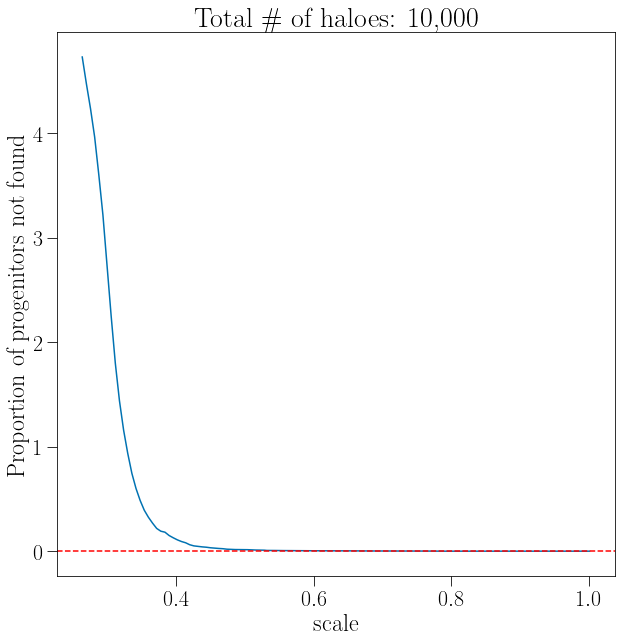

In [23]:
# number of nan's as a function fo scale
plt.figure(figsize=(10,10))
plt.plot(scales, [sum(np.isnan(ma_raw[:, i]))/len(ma) for i in range(len(scales))])
plt.axhline(0.0, color='r', linestyle='--')
plt.xlabel("\\rm scale")
plt.ylabel("\\rm Proportion of progenitors not found")
plt.title("\\rm Total \\# of haloes: 10,000")

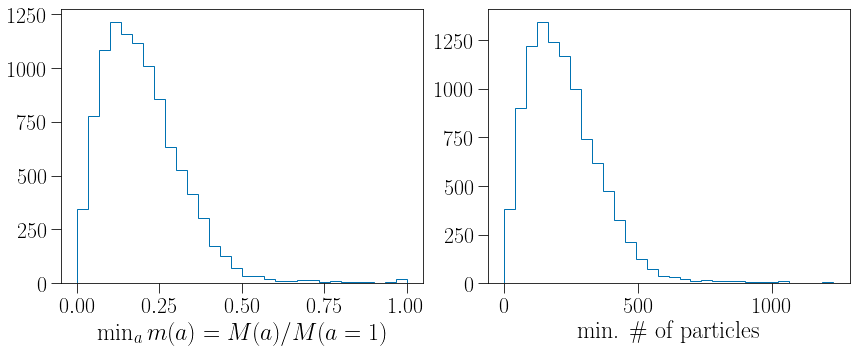

In [128]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
_ma_raw = ma_raw.copy()
_ma_raw = _ma_raw.T[mah_data['keep_scale']].T
_ma_raw[np.isnan(_ma_raw)] = 1.35e8 / np.mean(mah_data['cat']['mvir'])

min_ma = np.min(_ma_raw, axis=1)
min_ma_particles = min_ma * mah_data['cat_raw']['mvir'] / 1.35e8

ax1.hist(min_ma, bins=30, histtype='step')
ax1.set_xlabel(r"$\min_{a} m(a) = M(a) / M(a=1)$")

ax2.hist(min_ma_particles, bins=30, histtype='step')
ax2.set_xlabel(r"\rm min. \# of particles")
# ax2.set_xscale('log')

plt.tight_layout()

Text(0.5, 0, '$\\min_{a} m(a) = M(a) / M(a=1)$')

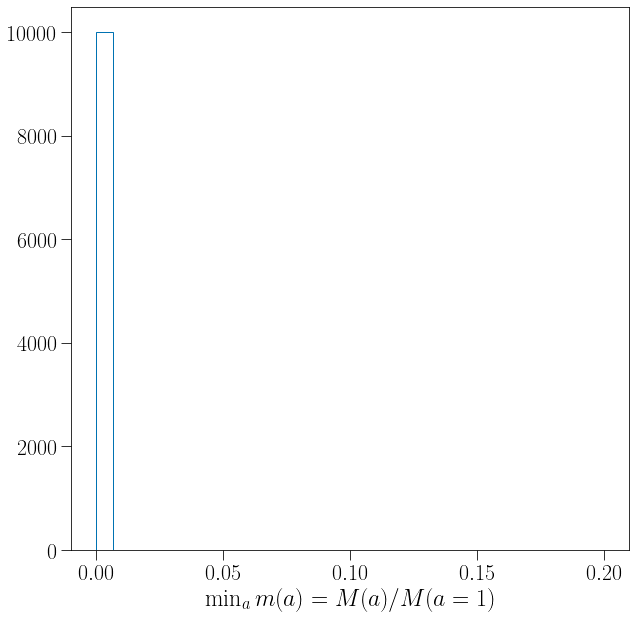

In [40]:
_ma_raw = ma_raw.copy()
_ma_raw[np.isnan(_ma_raw)] = 1.35e8 / np.mean(mah_data['cat']['mvir'])
plt.hist(np.min(_ma_raw, axis=1), bins=30, histtype='step', range=(0, 0.2))
plt.xlabel(r"$\min_{a} m(a) = M(a) / M(a=1)$")

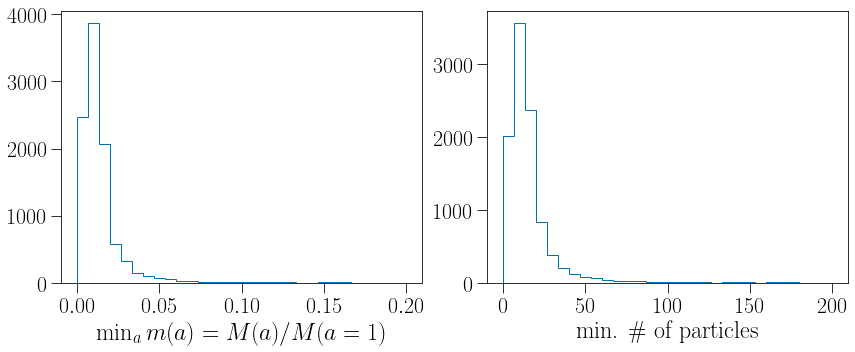

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
_ma_raw = ma_raw.copy()

min_ma = np.nanmin(_ma_raw, axis=1)
min_ma_particles = min_ma * mah_data['cat_raw']['mvir'] / 1.35e8

ax1.hist(min_ma, bins=30, histtype='step', range=(0, 0.2))
ax1.set_xlabel(r"$\min_{a} m(a) = M(a) / M(a=1)$")

ax2.hist(min_ma_particles, bins=30, histtype='step', range=(0, 200))
ax2.set_xlabel(r"\rm min. \# of particles")
# ax2.set_xscale('log')

plt.tight_layout()

# Example m(a)'s and a(m)'s 

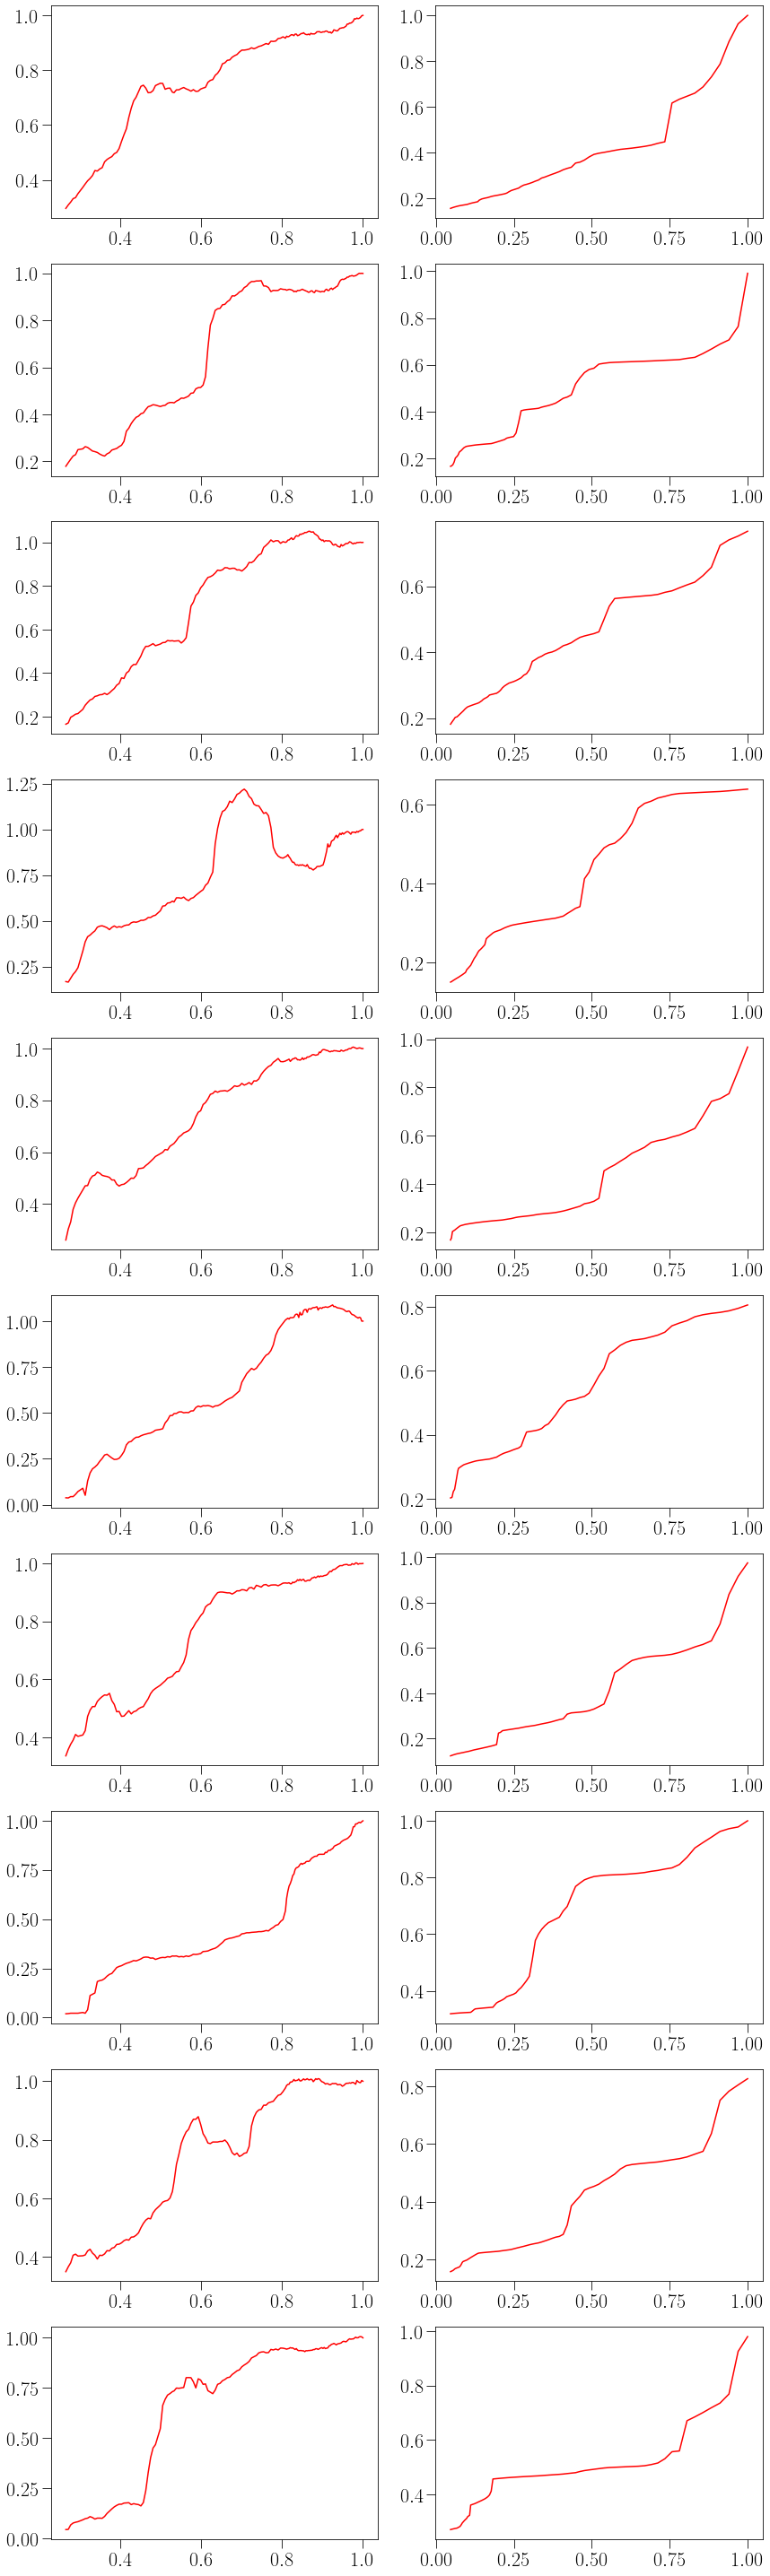

In [7]:
# examples of ma's and  am's 
fig, axes = plt.subplots(10, 2, figsize=(12, 40))
ma, am = mah_data['ma'], mah_data['am']
scales, mass_bins = mah_data['scales'], mah_data['mass_bins']
for i in range(len(axes)):
    idx = np.random.choice(range(len(ma)))
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]
    ma_i = ma[idx, :]
    am_i = am[idx, :]
    ax1.plot(scales, ma_i, c='r', linestyle='-')
    ax2.plot(mass_bins, am_i, c='r', linestyle='-')
plt.tight_layout()

# m(a) > 1 Haloes

In [71]:
first_masses = [] 
for i in range(len(ma_raw)):
    first_index = np.where(~np.isnan(ma_raw[i, :]))[0][0]
    first_mass = ma_raw[i, first_index]
    first_masses.append(first_mass)
first_masses = np.array(first_masses)

In [98]:
sum(np.nanmax(ma_raw[:, :25], axis=1) > 1.0)

/var/folders/yl/5w7yl6bn1tsc5fjrdtsrsjhh0000gn/T/ipykernel_9936/726817793.py:1: RuntimeWarning: All-NaN slice encountered
  sum(np.nanmax(ma_raw[:, :25], axis=1) > 1.0)


6

/var/folders/yl/5w7yl6bn1tsc5fjrdtsrsjhh0000gn/T/ipykernel_9936/1982029077.py:2: RuntimeWarning: All-NaN slice encountered
  for idx in np.where(np.nanmax(ma_raw[:, :25], axis=1) > 0.9)[0]:


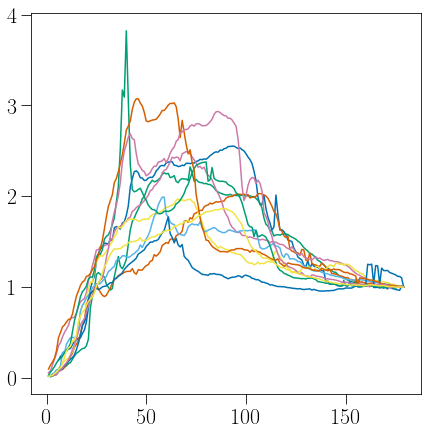

In [107]:
plt.figure(figsize=(7, 7))
for idx in np.where(np.nanmax(ma_raw[:, :25], axis=1) > 0.9)[0]: 
    plt.plot(ma_raw[idx])
    

/var/folders/yl/5w7yl6bn1tsc5fjrdtsrsjhh0000gn/T/ipykernel_9936/3440941052.py:2: RuntimeWarning: All-NaN slice encountered
  indices = np.where(np.nanmax(ma_raw[:, :25], axis=1) > 0.9)[0]


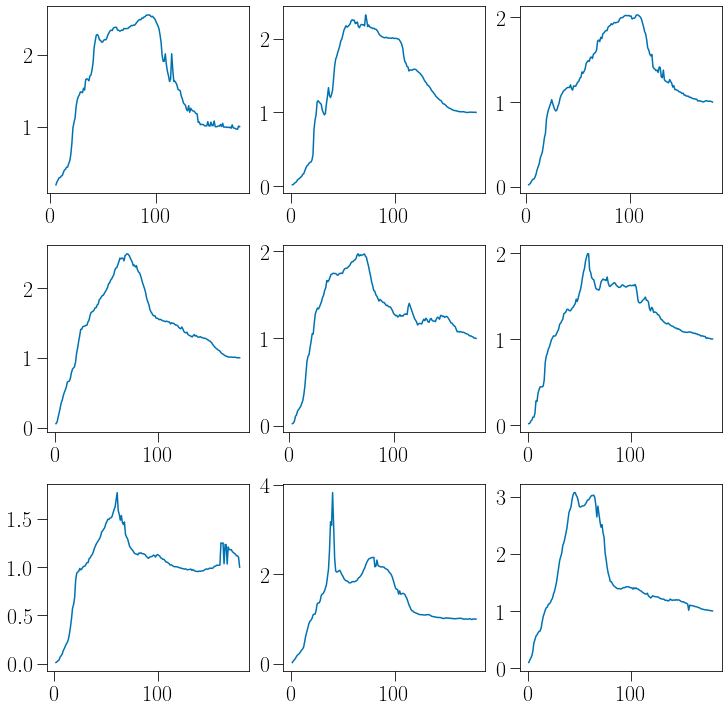

In [115]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
indices = np.where(np.nanmax(ma_raw[:, :25], axis=1) > 0.9)[0]
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.plot(ma_raw[indices[i]])
plt.tight_layout()

# Dummy test

In [6]:
name="m11"
path="../../../output"
cutoff_missing=0.01
cutoff_particle=0.1
particle_mass=1.35e8  # Bolshoi
particle_res=50
n_bins=100
m_version="vir"
output = f"{path}/output_{name}/"
cat_file = Path(output, "final_table.csv")
z_map_file = Path(output, "z_map.json")

# load all available scales and indices.
with open(z_map_file, "r") as fp:
    scale_map = json.load(fp)  # map from i -> scale
indices = np.array(list(scale_map.keys()))
scales = np.array(list(scale_map.values()))
sort_idx = np.argsort(scales)  # want order: early -> late. Low scales -> high scales (1.0)
indices = indices[sort_idx].astype(int)  # easier to handle.
scales = scales[sort_idx]

# load catalog.
hcat = halo_catalogs.HaloCatalog("Bolshoi", cat_file, label=name)
hcat.load_cat_csv()
cat = hcat.cat

In [7]:
ma_info = get_ma_info(cat, indices)

In [9]:
from relaxed.analysis import determine_cutoffs
min_scale, min_mass_bin = determine_cutoffs(ma_info["Mvir"], scales, cutoff_missing, cutoff_particle, particle_mass, particle_res)
print(min_scale, min_mass_bin)

0.0019292284972765225 0.047071131891948774
0.26435 0.047071131891948774


In [41]:
ma = ma_info['ma_vir'].copy()
ma[np.isnan(ma)] = particle_mass / np.nanmean(cat['mvir'])


In [44]:
am, mass_bins = get_am(ma, scales, min_mass_bin, n_bins=100)

In [48]:
am

array([[0.13021461, 0.1305428 , 0.13087181, ..., 0.3113155 , 0.31248731,
        0.3142226 ],
       [0.22123005, 0.22183748, 0.22391202, ..., 0.89520986, 0.9048395 ,
        0.91665044],
       [0.17159206, 0.17209002, 0.17258943, ..., 0.56316516, 0.59141497,
        0.84479296],
       ...,
       [0.22623416, 0.2278538 , 0.22948505, ..., 0.95388078, 0.96459267,
        1.00035   ],
       [0.16226557, 0.1639048 , 0.16550456, ..., 0.85753218, 0.91568971,
        0.98384983],
       [0.15872567, 0.1593223 , 0.15992118, ..., 0.82888826, 0.86909252,
        0.91335   ]])

In [51]:
sum(~np.isnan(np.sum(am, axis=1)))

9999

In [72]:
mass_bins[0] * 10**(11.22)  / 1.35e8

50.907576246368116